In [1]:
# Import the training data
import pandas as pd 

X_train = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/X_train.csv')
X_val = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/X_val.csv')
X_test = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/X_test.csv')
y_train = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/y_train.csv')
y_val = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/y_val.csv')
y_test = pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/NIMS/surrogate-DFT-ionic-conductivity/src/20250623_Li_migration/data/y_test.csv')

In [2]:
# Standardize dataset
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc = scaler_X.transform(X_val)
X_test_sc = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_sc = scaler_y.fit_transform(y_train)
y_val_sc = scaler_y.transform(y_val)
y_test_sc = scaler_y.transform(y_test)

In [3]:
# Tensoring the dataset
import torch
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
# Dataloader
from torch.utils.data import DataLoader

train_dataset = DataSet(X_train_sc, y_train_sc)
val_dataset = DataSet(X_val_sc, y_val_sc)
test_dataset = DataSet(X_test_sc, y_test_sc)

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size= 32, shuffle= False, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle= False, drop_last = True)

In [ ]:
# Define torch model
import torch
import torch.nn as nn

class DFTRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.linear_relu_stack(x)

In [6]:
# Create model instance
model = DFTRegressor(input_dim= X_train.shape[1], output_dim= y_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [7]:
# training loop
def train(model, train_loader, val_loader, optimizer, loss_fn, n_epochs= 200):
    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)
                val_loss += loss.item()
    
        avg_train_loss = train_loss/len(train_loader)
        avg_val_loss = val_loss/len(val_loader)
            
        print(f"Epoch {epoch}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    print(f' The best validation loss: {best_val_loss:.4f}')
    model.load_state_dict(best_model_state)
    return model

In [8]:
# Evaluation
import numpy as np

def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            test_loss += loss.item()

            all_preds.append(pred.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_test_loss = test_loss/len(test_loader)
    pred = np.vstack(all_preds)
    target = np.vstack(all_targets)
    print(f'Test loss: {avg_test_loss:.4f}')
    return pred, target

In [9]:
# Run training - eval
best_model = train(model, optimizer= optimizer, train_loader=train_loader, val_loader= val_loader, loss_fn=loss_fn, n_epochs=100)

y_pred, y_true = test(best_model, test_loader, loss_fn)

Epoch 0: train loss: 170.8226, val loss: 16.7314
Epoch 1: train loss: 136.8247, val loss: 15.7254
Epoch 2: train loss: 123.9969, val loss: 15.3432
Epoch 3: train loss: 114.2540, val loss: 14.0959
Epoch 4: train loss: 109.2316, val loss: 13.2919
Epoch 5: train loss: 105.9327, val loss: 13.2469
Epoch 6: train loss: 102.5026, val loss: 13.5448
Epoch 7: train loss: 97.1174, val loss: 13.5203
Epoch 8: train loss: 95.8002, val loss: 13.5596
Epoch 9: train loss: 93.3360, val loss: 11.6036
Epoch 10: train loss: 88.2207, val loss: 12.7358
Epoch 11: train loss: 87.9869, val loss: 12.1382
Epoch 12: train loss: 86.5789, val loss: 12.3609
Epoch 13: train loss: 86.4651, val loss: 12.4071
Epoch 14: train loss: 82.6812, val loss: 12.8276
Epoch 15: train loss: 80.5800, val loss: 11.5286
Epoch 16: train loss: 79.5923, val loss: 12.3101
Epoch 17: train loss: 79.9007, val loss: 11.9543
Epoch 18: train loss: 78.2633, val loss: 11.2148
Epoch 19: train loss: 75.9648, val loss: 11.6993
Epoch 20: train loss: 7

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

band_gap — RMSE: 0.7320, R²: 0.7122
formation_energy_per_atom — RMSE: 0.1616, R²: 0.8729
energy_above_hull — RMSE: 0.1096, R²: 0.2854
E_1D — RMSE: 0.2896, R²: 0.6481
E_2D — RMSE: 0.3787, R²: 0.7648
E_3D — RMSE: 1.2083, R²: 0.7495
em_min — RMSE: 0.4676, R²: 0.4302
em_mean — RMSE: 0.7940, R²: 0.5265
em_std — RMSE: 0.8864, R²: 0.5042
n_paths — RMSE: 7.8458, R²: 0.5731

Average RMSE: 1.2874
Average R²: 0.6067


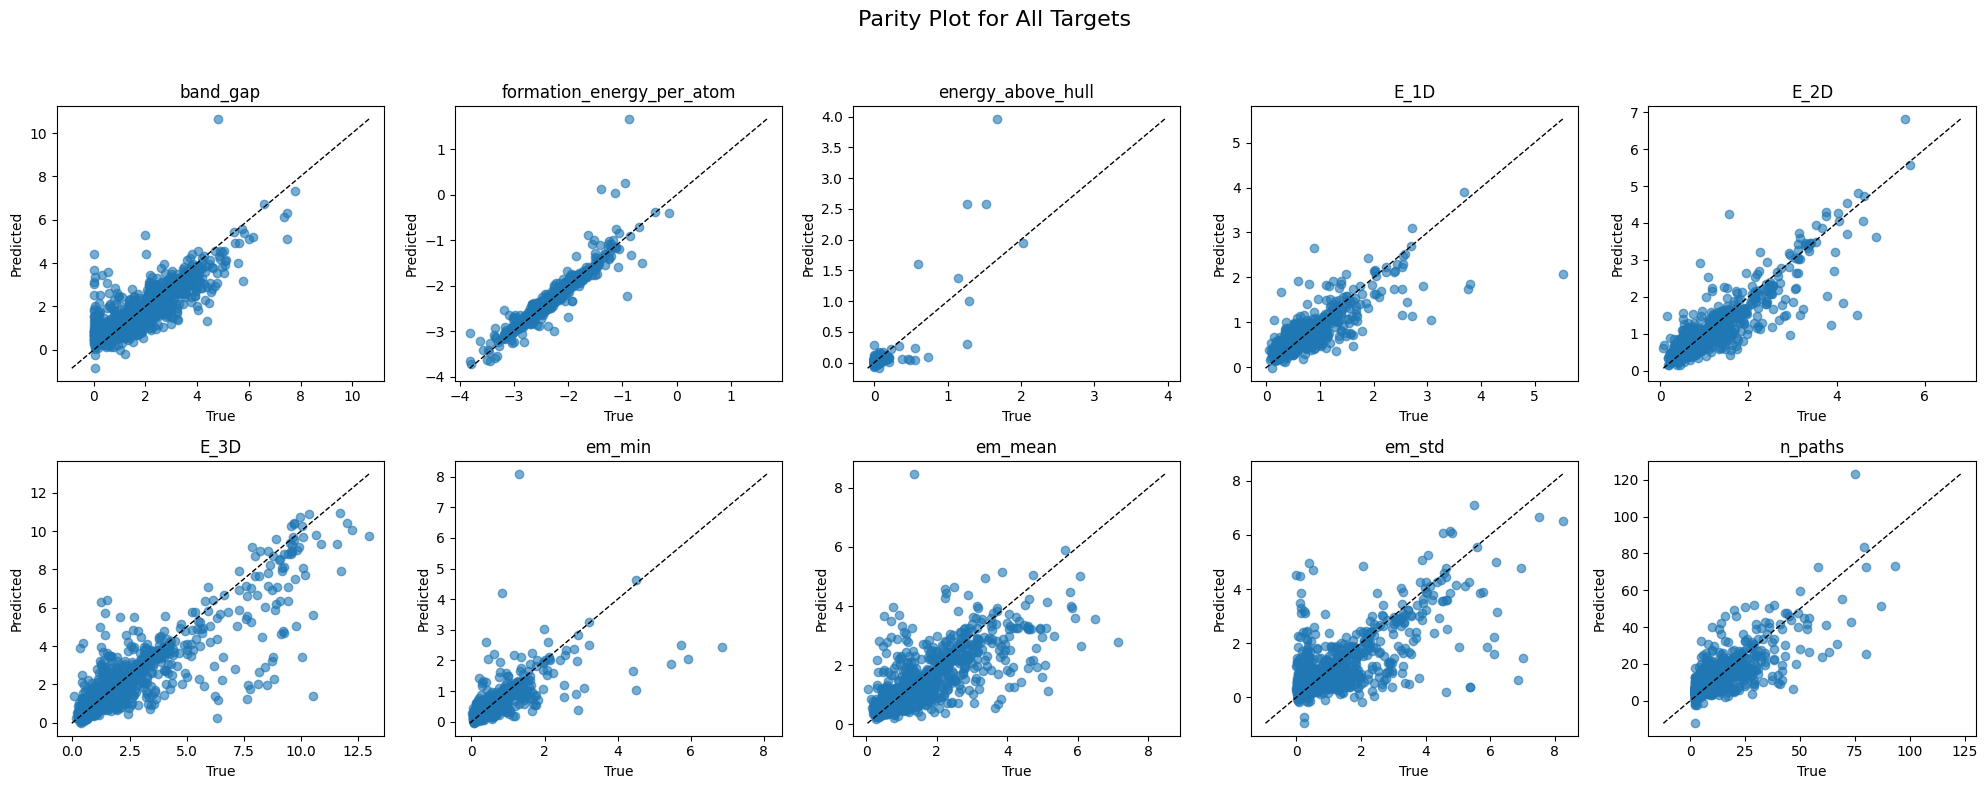

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Inverse transform if targets were standardized
y_true_orig = scaler_y.inverse_transform(y_true)
y_pred_orig = scaler_y.inverse_transform(y_pred)

# Get target names from original DataFrame
target_names = y_train.columns.tolist()

# Evaluate RMSE and R²
n_targets = y_true_orig.shape[1]
rmse_list = []
r2_list = []

for i in range(n_targets):
    rmse = mean_squared_error(y_true_orig[:, i], y_pred_orig[:, i], squared=False)
    r2 = r2_score(y_true_orig[:, i], y_pred_orig[:, i])
    rmse_list.append(rmse)
    r2_list.append(r2)
    print(f"{target_names[i]} — RMSE: {rmse:.4f}, R²: {r2:.4f}")

print(f"\nAverage RMSE: {np.mean(rmse_list):.4f}")
print(f"Average R²: {np.mean(r2_list):.4f}")

# Plot parity plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Parity Plot for All Targets", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.scatter(y_true_orig[:, i], y_pred_orig[:, i], alpha=0.6)
    min_val = min(y_true_orig[:, i].min(), y_pred_orig[:, i].min())
    max_val = max(y_true_orig[:, i].max(), y_pred_orig[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
    ax.set_title(target_names[i])
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted") 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()